This script implements the ACCV'18 paper "Continuous-time intensity estimation using event cameras"
Arxiv link: https://arxiv.org/pdf/1811.00386.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
#from skimage.measure import compare_psnr
from skimage.io import imread
from skimage.io import imsave
import utils.visualization as vs
import utils.events_processing as ep
import math
import tensorflow as tf

start time: 2.558515 
end time: 2.597280001
image shape: (2, 180, 240)
# of events: (14048,)
Binned evf shape: (11, 180, 240)
shape of event frames: (11, 180, 240)
Max value of evf: 1.0
Min value of evf: -1.0


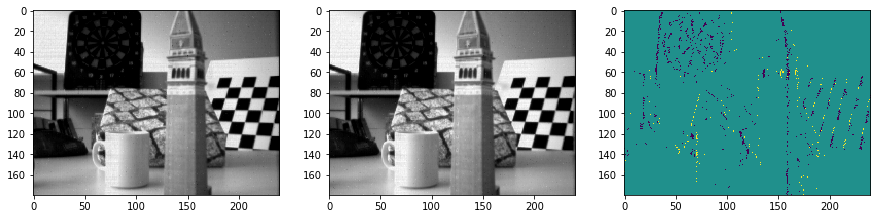

In [2]:
# load data (DAVIS)
davisDir = '/home/winston/data/davis/davis240/slider_depth'
imgDir = os.path.join(davisDir, 'images')
imgFileList = np.sort(os.listdir(imgDir))
imgPairId = [66, 67]
imgPair = np.array([imread(os.path.join(imgDir,imgFileList[imgPairId[0]]))/255.0, 
                    imread(os.path.join(imgDir,imgFileList[imgPairId[1]]))/255.0])
timeStart, timeEnd = ep.findTimeWindowFromId(os.path.join(davisDir, 'images.txt'), imgFileList, imgPairId)
print("start time:", timeStart, "\nend time:", timeEnd)
print("image shape:", np.shape(imgPair))
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.imshow(imgPair[0], cmap = 'gray')
plt.subplot(132)
plt.imshow(imgPair[1], cmap = 'gray')
eventsTime, eventsXYP = ep.loadEventsWithinTimeWindow(os.path.join(davisDir, 'events.txt'), timeStart, timeEnd)

eventFrames = ep.binEventFrames(eventsTime, eventsXYP, method = 1)
plt.subplot(133)
plt.imshow(eventFrames[0])
print("shape of event frames:", np.shape(eventFrames))
print("Max value of evf:", np.max(eventFrames))
print("Min value of evf:", np.min(eventFrames))

In [3]:
class updateLogs():
    def __init__(self, logOfFrame):
        self.lmin = np.min(logOfFrame)
        self.lmax = np.max(logOfFrame)
        print("L_min:", self.lmin, "\tl_max:", self.lmax)
        self.k = 0.05*(self.lmax - self.lmin)
        self.L1 = self.lmin + self.k
        self.L2 = self.lmax - self.k
        self.a1 = 2*math.pi
        self.a0 = self.a1
        self.log0 = logOfFrame
        self.sigma_c = 0.3
        print("Initialized L0", np.shape(self.log0))
        print("sigma*c:", self.sigma_c)

    def updateAlpha(self, Lf):
        self.lambda0 = 0.1
        if Lf < self.L1 and Lf >= self.lmax:
            self.a0 = self.lambda0*self.a1 + (1 - self.lambda0)*self.a1*(Lf - self.lmin)/(self.L1 - self.lmin)
        elif Lf > self.L2 and Lf < self.lmax:
            self.a0 = self.lambda0*self.a1 + (1 - self.lambda0)*self.a1*(Lf - self.lmax)/(self.L2 - self.lmax)
        else:
            self.a0 = self.a1
        return self.a0
    

L_min: -23.025850929940457 	l_max: -0.6737290945066899
Initialized L0 (180, 240)
sigma*c: 0.3


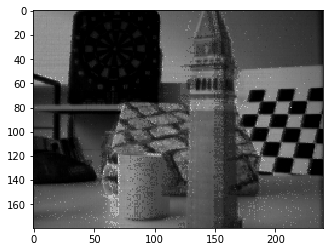

In [4]:
eps = 1e-10
logOfFrame = np.log(imgPair[0]+eps)
logs = updateLogs(logOfFrame)
for i in range(len(eventsTime)):
    dt = eventsTime[i] - timeStart
    ex = eventsXYP[i,0]
    ey = eventsXYP[i,1]
    ep = eventsXYP[i,2]
    logs.log0[ey, ex] = np.exp(-logs.a0*dt)*logs.log0[ey, ex] + (1 - np.exp(-logs.a0*dt))*logOfFrame[ey, ex]
    logs.log0[ey, ex] = logs.log0[ey, ex] + ep * logs.sigma_c
    logs.updateAlpha(logOfFrame[ey, ex])

img = np.exp(logs.log0) - eps
plt.imshow(img, cmap = 'gray')


In [5]:
# save file
savePath = 'results/pred-slider_depth-%03d-%03d/' % (imgPairId[0], imgPairId[1])
if not os.path.isdir(savePath):
    os.mkdir(savePath)
    os.mkdir(os.path.join(savePath, 'accv18'))
    os.mkdir(os.path.join(savePath, 'ground_truth'))
    os.mkdir(os.path.join(savePath, 'mbr'))
    
# save ground truth images
## save low-res images
if not os.path.exists(os.path.join(savePath, 'ground_truth', 'low-res*')):
    imsave(os.path.join(savePath, 'ground_truth', 'low-res-1.png'), imgPair[0])
    imsave(os.path.join(savePath, 'ground_truth', 'low-res-2.png'), imgPair[1])
if not os.path.exists(os.path.join(savePath, 'ground_truth', 'evf-1f.png')):
    evf_float = (eventFrames - np.min(eventFrames))/(np.max(eventFrames) - np.min(eventFrames))
    imsave(os.path.join(savePath, 'ground_truth', 'evf-1f.png'), np.squeeze(evf_float))

if not os.path.exists(os.path.join(savePath, 'accv18', 'rec.png')):
    imsave(os.path.join(savePath, 'accv18', 'rec.png'), vs.imgBetween01(img))
    
psnr_file = os.path.join(savePath, 'accv18', 'psnr_ssim.txt')
if os.path.exists(psnr_file):
    os.remove(psnr_file)
with open(psnr_file, 'w') as f:
    f.write('psnr: %03f\n' % (psnr(imgPair[1], img)))
    f.write('ssim: %04f' % (ssim(imgPair[1], img)))
    



/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [10]:
# models
def init_hres(config, lres_gt):
    # input lres_gt should be in shape (t, y, x, c)
    if config.syn_mode == 'i':
        lres_mean = np.expand_dims(np.mean(lres_gt, axis = 0), axis = 0)
        #print("shape of 'lres_mean'", np.shape(lres_mean))
        # (1, y, x, c)
        lres_start = tf.Variable(np.expand_dims(lres_gt[0], axis = 0), dtype = tf.float32)
        lres_end = tf.Variable(np.expand_dims(lres_gt[1], axis = 0), dtype = tf.float32)
        # init hres
        for i in range(config.unknown+2):
            a = i / (config.unknown + 1)
            if i == 0:
                hres_init = lres_start
            else:
                frame = (1-a)*lres_start + a*lres_end
                hres_init = tf.concat([hres_init, tf.Variable(frame, dtype = tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    elif config.syn_mode == 'p':
        for i in range(config.unknown+1):
            if i == 0:
                hres_init = tf.Variable(lres_gt, dtype= tf.float32)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_gt, dtype= tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    else:
        for i in range(config.unknown):
            if i == 0:
                hres_init = tf.Variable(lres_gt, dtype= tf.float32)
            else:
                hres_init = tf.concat([hres_init, tf.Variable(lres_gt, dtype= tf.float32)], 0)
        hres_init = tf.expand_dims(hres_init, axis = 0)
    print("hres_init shape:", np.shape(hres_init))
    return hres_init

def frame_model(config, hres_tensor):
    if config.syn_mode == 'i':
        lres_tensor = tf.transpose(tf.gather_nd(tf.transpose(hres_tensor, perm = [1,2,3,4,0]),
                                                indices = [[0],[config.unknown+1]]),
                                   perm = [4,0,1,2,3])
    elif config.syn_mode == 'p':
        lres_tensor = tf.transpose(tf.gather_nd(tf.transpose(hres_tensor, perm=[1,2,3,4,0]),
                                                indices = [[0]]), perm=[4,0,1,2,3])
    else:
        lres_tensor = tf.reduce_sum(hres_tensor, 1, keepdims = True)
    if config.verbose == 1:
        print("----Finished generating lres_tensor, shape", np.shape(lres_tensor))
    return lres_tensor

def event_model(config, hres_tensor):
    hres_relu = tf.nn.relu(hres_tensor)
    tanh_coef = tf.constant(config.tanh_coef)
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    k_tyx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=1), axis=2), axis=3)
    if config.c_channel == 3:
        k_tyxi = tf.expand_dims(tf.concat([k_tyx, k_tyx, k_tyx], axis=3), axis=4)
        k_tyxio = tf.concat([k_tyxi, k_tyxi, k_tyxi], axis=4)
    else:
        k_tyxio = tf.expand_dims(k_tyx, axis = 4)
    evf_tanh = tf.tanh(
        tanh_coef * tf.nn.convolution(input=hres_relu, filter=k_tyxio, padding="VALID", data_format="NDHWC"))
    if config.verbose == 1:
        print("evf_tanh, shape:", np.shape(evf_tanh))
    return evf_tanh

def tv_2d(config, hres_tensor):
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    kx = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=0), axis=2), axis=3)
    ky = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=1), axis=2), axis=3)
    if config.c_channel == 3:
        kxi = tf.expand_dims(tf.concat([kx, kx, kx], axis=3), axis=4)
        kxio = tf.concat([kxi, kxi, kxi], axis=4)
        kyi = tf.expand_dims(tf.concat([ky, ky, ky], axis=3), axis=4)
        kyio = tf.concat([kyi, kyi, kyi], axis=4)
    else:
        kxio = tf.expand_dims(kx, axis = 4)
        kyio = tf.expand_dims(ky, axis = 4)

    dx = tf.nn.convolution(input=hres_tensor, filter=kxio, padding="SAME", data_format="NDHWC")
    dy = tf.nn.convolution(input=hres_tensor, filter=kyio, padding="SAME", data_format="NDHWC")
    return tf.norm(dx + dy, ord=1)

def tv_t(config, hres_tensor):
    kernel = tf.constant([-1, 1], dtype=tf.float32)
    kt = tf.expand_dims(tf.expand_dims(tf.expand_dims(kernel, axis=0), axis=0), axis=3)
    if config.c_channel == 3:
        kti = tf.expand_dims(tf.concat([kt, kt, kt], axis=3), axis=4)
        ktio = tf.concat([kti, kti, kti], axis=4)
    else:
        ktio = tf.expand_dims(kt, axis = 4)
    dt = tf.nn.convolution(input=hres_tensor, filter=ktio, padding="VALID", data_format="NDHWC")
    return tf.norm(dt, ord=1)

def loss_pix_tv(config, ph, hres_tensor, lres_tensor, evf_tensor):
    frame_loss = tf.norm(ph.lres_gt - tf.squeeze(lres_tensor, [0]), ord = 1)
    event_loss = tf.constant(config.ev_weight)*tf.norm(ph.evf_gt - tf.squeeze(evf_tensor, [0]), ord = 1)
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
    return frame_loss + event_loss + tv_loss

In [15]:
# hres_gt = np.expand_dims(np.transpose(np.array([vid[0,:,:], vid[num_evf,:,:]]), (1,2,0)), 0)
lres_gt = np.expand_dims(np.expand_dims(imgPair[0], 0), 3)
evf_gt = np.expand_dims(np.expand_dims(eventFrames, 3), 0)
print("shape of lres_gt", np.shape(lres_gt))
print("shape of evf_gt", np.shape(evf_gt))
print("Max value %0.2f, min value %0.2f" % (np.amax(lres_gt), np.amin(lres_gt)))

shape of lres_gt (1, 180, 240, 1)
shape of evf_gt (1, 11, 180, 240, 1)
Max value 0.51, min value 0.00


In [16]:
# config
class config():
    def __init__(self, hres_dim=None, lres_dim=None, evf_dim=None, syn_mode = 'i', unknown_t=None,
                 c_channel = 3, verbose = 0):
        self.syn_mode = syn_mode
        self.hres_dim = hres_dim
        self.unknown = unknown_t
        self.lres_dim = lres_dim
        self.evf_dim = evf_dim
        self.c_channel = c_channel
        self.verbose = verbose

        # events
        self.ev_weight = 6e-1
        self.tanh_coef = 7.0

        # hres_tv
        self.tv_coef_xy = 5e-2
        self.tv_coef_t = 1e-1

        # learning
        self.lr_init = 20e-3
        self.lr_update = 100
        self.epochs = 300
        self.beta1 = 0.9
        self.beta2 = 0.99

class place_holder():
    def __init__(self, config):
        self.learning_rate = tf.placeholder(tf.float32)
        self.lres_gt = tf.placeholder(tf.float32, shape = config.lres_dim)
        self.evf_gt = tf.placeholder(tf.float32, shape = config.evf_dim)

In [18]:
ev_dim0, ev_dimt, dimy, dimx, dimc = np.shape(evf_gt)
hres_dimt = ev_dimt + 1
res_config = config(hres_dim = (ev_dim0, hres_dimt, dimy, dimx, dimc), 
                    evf_dim = np.shape(evf_gt), lres_dim = np.shape(lres_gt),
                    syn_mode = 'p', unknown_t = ev_dimt, c_channel = 1)
res_ph = place_holder(res_config)

hres_tensor = init_hres(res_config, lres_gt)
lres_tensor = frame_model(res_config, hres_tensor)
evf_tensor = event_model(res_config, hres_tensor)
loss = loss_pix_tv(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)
optimizer = tf.train.AdamOptimizer(learning_rate = res_ph.learning_rate, beta1 = res_config.beta1, beta2 = res_config.beta2)
opt_min = optimizer.minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

iloss = np.empty((res_config.epochs,))
for iepoch in range(res_config.epochs):
    if iepoch == 0:
        res_config.lr = res_config.lr_init
    hres_rec, iloss[iepoch], _ = sess.run([hres_tensor, loss, opt_min],
                               feed_dict={res_ph.lres_gt: lres_gt, 
                                          res_ph.evf_gt: evf_gt, 
                                          res_ph.learning_rate: res_config.lr})
    if iepoch % res_config.lr_update == 0:
        print("Epoch:", iepoch, "learning rate: %5f" % res_config.lr)
        if iepoch > 0:
            res_config.lr *= 0.1
print("hres_rec shape:", np.shape(hres_rec))
print("Max value %0.2f, min value %0.2f" % (np.amax(hres_rec), np.amin(hres_rec)))
plt.plot(range(res_config.epochs), iloss)
plt.show()

hres_init shape: (1, 12, 180, 240, 1)


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node convolution_8 (defined at <ipython-input-10-1e9e59e620b7>:91) ]]
	 [[node add_7 (defined at <ipython-input-10-1e9e59e620b7>:98) ]]

Caused by op 'convolution_8', defined at:
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-87033a689c06>", line 11, in <module>
    loss = loss_pix_tv(res_config, res_ph, hres_tensor, lres_tensor, evf_tensor)
  File "<ipython-input-10-1e9e59e620b7>", line 97, in loss_pix_tv
    tv_loss = tf.constant(config.tv_coef_xy)*tv_2d(config, hres_tensor) + tf.constant(config.tv_coef_t)*tv_t(config, hres_tensor)
  File "<ipython-input-10-1e9e59e620b7>", line 91, in tv_t
    dt = tf.nn.convolution(input=hres_tensor, filter=ktio, padding="VALID", data_format="NDHWC")
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 851, in convolution
    return op(input, filter)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 966, in __call__
    return self.conv_op(inp, filter)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 591, in __call__
    return self.call(inp, filter)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 208, in __call__
    name=self.name)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1440, in conv3d
    dilations=dilations, name=name)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/winston/anaconda3/envs/py37ml/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node convolution_8 (defined at <ipython-input-10-1e9e59e620b7>:91) ]]
	 [[node add_7 (defined at <ipython-input-10-1e9e59e620b7>:98) ]]
